In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PandasTools
import pandas as pd

In [2]:
df = pd.read_csv('DEDuCT_ChemicalBasicInformation.csv')

In [3]:
df_smiles = df['SMILES (Canonical)']
df_mol = [Chem.MolFromSmiles(x) for x in df_smiles]
len(df_mol)

686

# Selecting the electrophiles

In [4]:
# SMARTS Patterns for electrophiles
patt1 = Chem.MolFromSmarts('[C]=[C]-[CX3](=[O])[*]') # Vinyl Carbonyl
patt2 = Chem.MolFromSmarts('[#6][CX3](=[O])[#6]') # Ketone
patt3 = Chem.MolFromSmarts('[*][CX3](=[O])[CX4]-[F,Cl,Br,I]') # Halomethyl Carbonyl
patt4 = Chem.MolFromSmarts('[O-0X1]=[C]1[C][C][N]1') # Beta-Lactam
patt5 = Chem.MolFromSmarts('[C,c]-[C,c]#[N,n]') # Nitrile
patt6 = Chem.MolFromSmarts('[C;r3][O;r3][C;r3]') # Epoxode
patt7 = Chem.MolFromSmarts('[#6][P]([O])([O])=O') # Phosphonate
patt8 = Chem.MolFromSmarts('[C]=[C]-[S](=[O])(=[O])[*]') # Vinyl Sulfonyl
patt9 = Chem.MolFromSmarts('[CX4]-[F,Br,Cl,I]') # Alyl Halide # this one was not included
patt10 = Chem.MolFromSmarts('[OX2H][CX4][OX2][#6]') # Hemiacetal # this one was not included
patt11 = Chem.MolFromSmarts('[#6][S][S][#6]') # Disulfide
patt12 = Chem.MolFromSmarts('[CX4,c]-[SX2H1,SX1-]') # Thiol # this one was not included
patt13 = Chem.MolFromSmarts('[#6]-[CX3](=O)-[OX2H1,OX1-]') # Carboxylic Acid
patt14 = Chem.MolFromSmarts('[#6][S](=O)(=O)[F,Cl,Br,I]') # Sulfonyl Halide
patt15 = Chem.MolFromSmarts('[C;r3][N;r3][C;r3]') # Aziridine # this one was not included
patt16 = Chem.MolFromSmarts('[#6][S](=O)(=O)[F,Cl,Br,I]') # Sulfonyl Halide
patt17 = Chem.MolFromSmarts('O=[#6]-1-[#6]-[#6]-[#6]-[#8]-1') # Gamma-lactone
patt18 = Chem.MolFromSmarts('[#6][CX3](=[O])-[O]-[#6]') # Ester
patt19 = Chem.MolFromSmarts('[#6]:[#6]:[#6]~O') # Aromatic michael acceptor
patt20 = Chem.MolFromSmarts('[#7]-[#6]=[#8]') # Aromatic michael acceptor


matches = []
for s in df_mol:
    if s.HasSubstructMatch(patt2) or s.HasSubstructMatch(patt1) or s.HasSubstructMatch(patt20) or s.HasSubstructMatch(patt3) or s.HasSubstructMatch(patt4) or s.HasSubstructMatch(patt5) or s.HasSubstructMatch(patt6) or s.HasSubstructMatch(patt7) or s.HasSubstructMatch(patt8) or s.HasSubstructMatch(patt11) or s.HasSubstructMatch(patt13) or s.HasSubstructMatch(patt14) or s.HasSubstructMatch(patt16) or s.HasSubstructMatch(patt17) or s.HasSubstructMatch(patt8) or s.HasSubstructMatch(patt19):
      matches.append(1)
    else:
        matches.append(0)
print(len(matches))
df['Matches'] = matches


686


In [5]:
# Remove Matches 0 for the electrophiles classification
df= df[df['Matches'] != 0]
df.drop(['CAS Number','PubChem identifier','Name','IUPAC_Name','Matches','INCHI','INCHI_Key'], inplace=True, axis=1)
PandasTools.AddMoleculeColumnToFrame(df, 'SMILES (Canonical)', 'Molecule', includeFingerprints=True)
len(df)

367

In [24]:
# Cleaned the df for unwanted molecules
df_cleaned=df.drop([12,31,36,38,68,72,63,60,119,145,137,130,218,186,197,198,185,250,243,234,235,224,225,228,230,283,273,372,369,364,407,400,384,439,440,428,429,432,415,489,452,447,520,511,512,510,493,495,497,498,559,534,525,526,595,598,599,608,679,675,676,668,685,124,149,387,408,556,510,242,76])

In [21]:
# Download the file
df_cleaned.drop(['Molecule'], inplace=True, axis=1)
df_cleaned.to_csv('Smiles_Electrophiles.csv', index=False, sep=',')

# Clustering the molecules

In [22]:
# Clustering the molecules

import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

In [23]:
compounds = []
for _,identifier, smiles in df_cleaned[['Primary identifier','SMILES (Canonical)']].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), identifier))
    
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 297
Fingerprint length per compound: 2048


In [10]:
# Function that calculates a Tanimoto distance matrix
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # The first and last items in the list are skipped to not compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [11]:
# Clustering function
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters


In [12]:
# Run the clustering procedure for the dataset and chose the right cluster
cutoffs = [0.1,0.2,0.3,0.4,0.5]
for c in cutoffs:
    clusters = cluster_fingerprints(fingerprints, cutoff=c)

    # Give a short report about the numbers of clusters and their sizes
    num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
    num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
    num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
    num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

    print('For cutoff: ',c)
    print("total # clusters: ", len(clusters))
    print("# clusters with only 1 compound: ", num_clust_g1)
    print("# clusters with >5 compounds: ", num_clust_g5)
    print("# clusters with >25 compounds: ", num_clust_g25)
    print("# clusters with >100 compounds: ", num_clust_g100)
    print(' ')
    # NBVAL_CHECK_OUTPUT

For cutoff:  0.1
total # clusters:  238
# clusters with only 1 compound:  200
# clusters with >5 compounds:  1
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0
 
For cutoff:  0.2
total # clusters:  199
# clusters with only 1 compound:  154
# clusters with >5 compounds:  6
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0
 
For cutoff:  0.3
total # clusters:  171
# clusters with only 1 compound:  130
# clusters with >5 compounds:  8
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0
 
For cutoff:  0.4
total # clusters:  141
# clusters with only 1 compound:  98
# clusters with >5 compounds:  8
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0
 
For cutoff:  0.5
total # clusters:  112
# clusters with only 1 compound:  71
# clusters with >5 compounds:  9
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0
 


Number of clusters: 171 from 297 molecules at distance cut-off 0.30
Number of molecules in largest cluster: 15
Similarity between two random points in same cluster: 0.75
Similarity between two random points in different cluster: 0.19


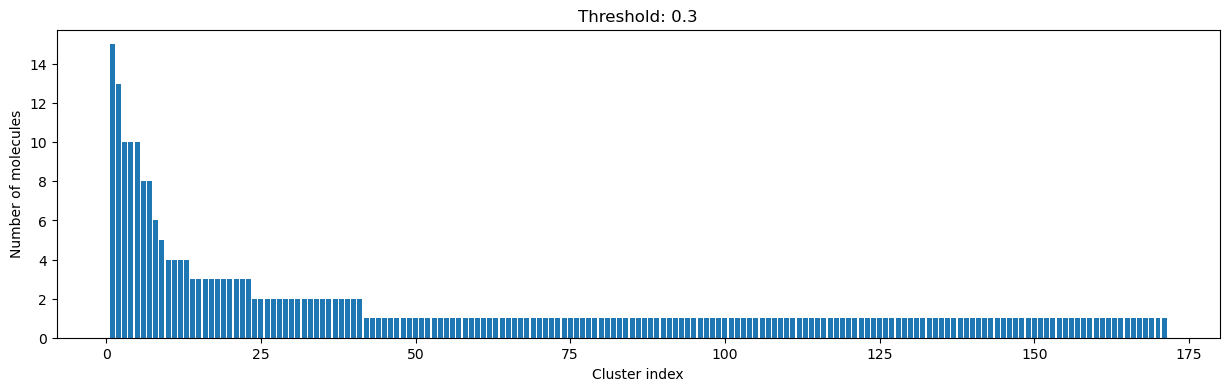

In [27]:
# Plot the size of the clusters - change value of cutoff for the cutoff of interest
cutoff = 0.3
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
ax.set_title(f"Threshold: {cutoff:3.1f}")

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

#fig.savefig(
#    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
#    dpi=300,
#    bbox_inches="tight",
#    transparent=True,
#)

25 Molecules from n largest cluster:


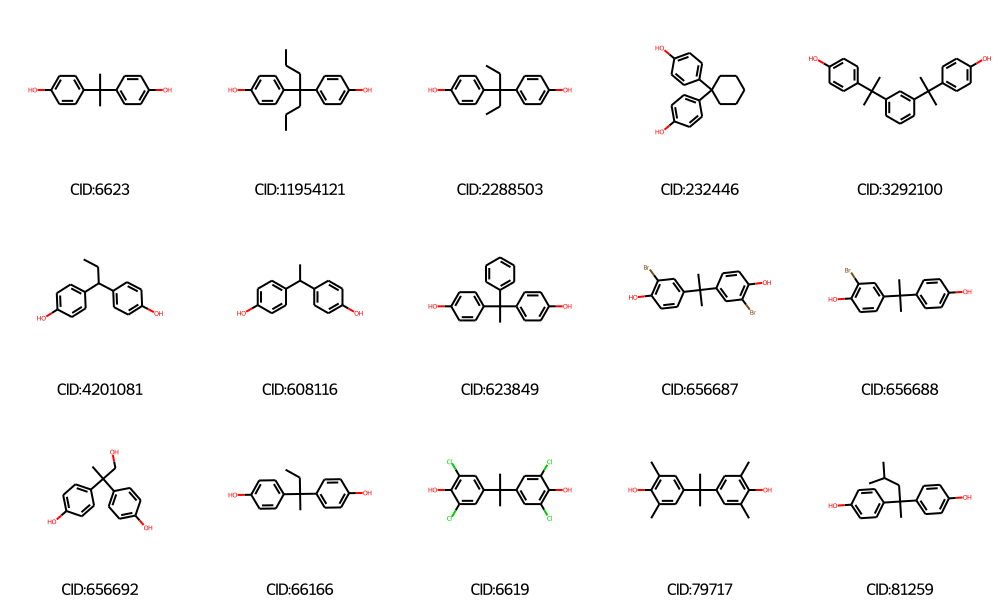

In [28]:
# Visualising m molecules for cluster n
n = 0
m = 25
print("25 Molecules from n largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[n][:m]],
    legends=[compounds[i][1] for i in clusters[n][:m]],
    molsPerRow=5,
    )

45 molecules from first 45 clusters:


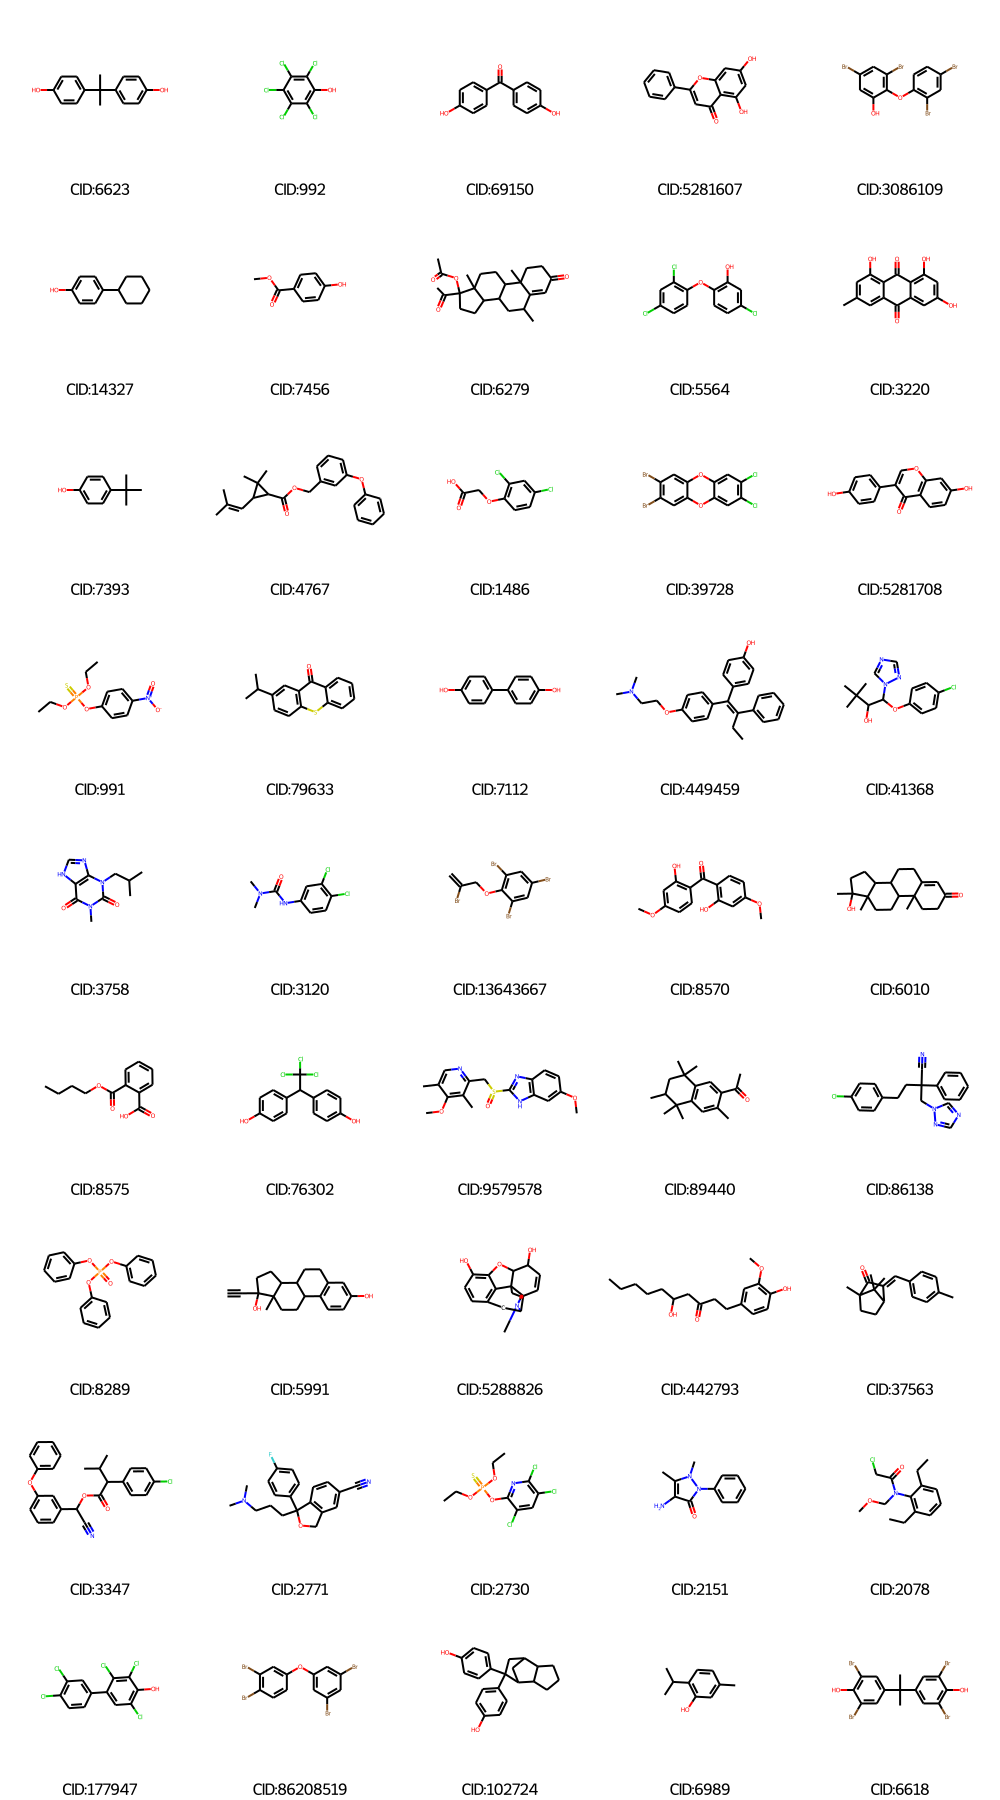

In [29]:
print("45 molecules from first 45 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(45)],
    legends=[compounds[clusters[i][0]][1] for i in range(45)],
    molsPerRow=5,
)


In [30]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 171


In [31]:
# Sort the molecules within a cluster based on their similarity to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)


In [ ]:
# Display the cluster_centers
df_clusters_centers = pd.DataFrame(cluster_centers, columns=['Molecule','Identifier'])
df_clusters_centers

In [34]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
while index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 3 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 3
    # If the cluster is between 4 and 10, take 1 compound
    if 10 <= sorted_clusters[index][0] <= 4:
        num_compounds = 1
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[-1:]]
    index += 1
print("# Selected molecules:", len(selected_molecules))

# Selected molecules: 212


In [35]:
# Function to find the middle of a list

def find_middle(lst):
    if not lst:  # Check if the list is empty
        return "The list is empty."
 
    length = len(lst)  # Get the length of the list
 
    if length % 2 != 0:  # Check if the length is odd
        middle_index = length // 2
        return lst[middle_index]
 
    # If the length is even
    first_middle_index = length // 2 - 1
    second_middle_index = length // 2
    return (lst[second_middle_index])

## Select a number of molecules from the first n clusters

In [37]:
# Selecting certain molcules for the first n clusters

n = 40

selected_molecules = cluster_centers[0:n+1].copy()

for cluster in sorted_clusters:
    if len(cluster[1]) ==14:
        index_molecule = [cluster[1][-1], cluster[1][2], cluster[1][7], cluster[1][11], cluster[1][0]]
        print(index_molecule)
        selected_molecules += [compounds[i] for i in index_molecule]
    if 10 < len(cluster[1]) < 14:
        index_molecule = [cluster[1][-1], cluster[1][2], cluster[1][7]]
        print(index_molecule)
        selected_molecules += [compounds[i] for i in index_molecule]
    if 4 < len(cluster[1]) <= 10:
        middle = find_middle(cluster[1])
        print(middle)
        #index_molecule = [cluster[1][-1], cluster[1][middle]]
        selected_molecules += [compounds[cluster[1][-1]]]
        selected_molecules += [compounds[middle]]
    if 3<= len(cluster[1]) <= 4:
        selected_molecules += [compounds[cluster[1][-1]]]
        
print("# Selected molecules:", len(selected_molecules))
df_selected_molecules = pd.DataFrame(selected_molecules, columns=['Molecule','Identifier'])

[221, 260, 210, 216, 102]
[166, 28, 269]
78
271
42
62
279
8
# Selected molecules: 66


## Final database fo selected molecules (selected molecules in n first clusters + rest of the molecules i.e. single clusters)

/home/sguilber/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(


,Primary identifier,SMILES (Canonical),Molecule
3,CID:10017512,COC1=C(C=CC(=C1)C2=CC(=O)C3=CC=CC=C3O2)[N+](=O...,
7,CID:102614,C1=CC(=CC=C1CC(C#N)C2=CC=C(C=C2)O)O,
8,CID:102724,C1CC2C(C1)C3CC2CC3(C4=CC=C(C=C4)O)C5=CC=C(C=C5)O,
11,CID:1046,C1=CN=C(C=N1)C(=O)N,
19,CID:10631,CC1CC2C(CCC3(C2CCC3(C(=O)C)O)C)C4(C1=CC(=O)CC4)C,
...,...,...,...
680,CID:980,C1=CC(=CC=C1[N+](=O)[O-])O,
681,CID:9880,CC(=O)C1(CCC2C1(CCC3C2C=C(C4=CC(=O)C5CC5C34C)C...,
682,CID:991,CCOP(=S)(OCC)OC1=CC=C(C=C1)[N+](=O)[O-],
683,CID:992,C1(=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl)O,

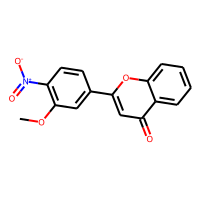
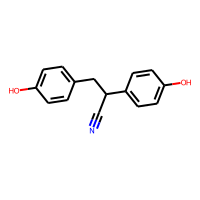
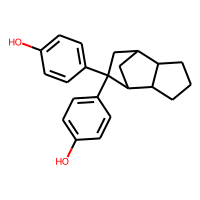
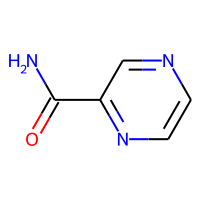
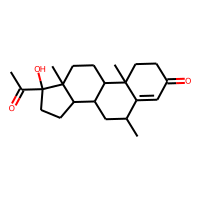
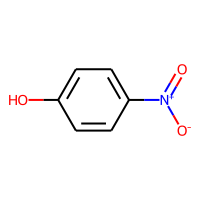
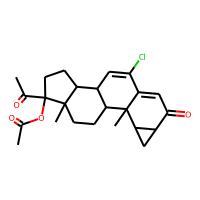
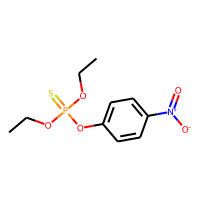
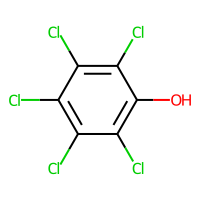
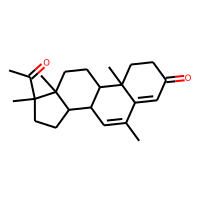

In [49]:
list_selected_molecules = df_selected_molecules['Identifier'].values.tolist()
single_clusters = cluster_centers[41:]
df_single_clusters = pd.DataFrame(single_clusters, columns=['Molecule','Identifier'])

list_selected_single = df_single_clusters['Identifier'].values.tolist()
list_selected = list_selected_molecules + list_selected_single
len(list_selected)

df_selected = df.loc[df['Primary identifier'].isin(list_selected)]
PandasTools.AddMoleculeColumnToFrame(df_selected, 'SMILES (Canonical)', 'Molecule', includeFingerprints=True)

df_selected.to_csv('selected_molecules.csv', index=False, sep=',')
df_selected